In [66]:
import os, sys, time, math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
np.random.seed(80)

<h1>  Loading training, test, validation dataset </h1>

In [67]:
mnist = input_data.read_data_sets("MNIST_data/",reshape=False,one_hot=True)

x_train, y_train           = mnist.train.images, mnist.train.labels
x_validation, y_validation = mnist.validation.images, mnist.validation.labels
x_test, y_test             = mnist.test.images, mnist.test.labels

num_classes = 10
x_train = (x_train.reshape(-1, 784)).T
x_validation = (x_validation.reshape(-1, 784)).T
x_test = (x_test.reshape(-1, 784)).T


y_train = (y_train.reshape(-1, 10)).T
y_validation = (y_validation.reshape(-1, 10)).T
y_test = (y_test.reshape(-1, 10)).T

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<h1> PART A: Model architecture and hyperparameters</h1>

In [68]:
input_dim = 784
hidden_dim = 100
output_dim = 10


EPOCHS = 30
lr = 0.01


beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8

eps = 1e-200

architecture = [{'input_dim': input_dim, 'output_dim': hidden_dim, 'activation': 'relu'},
        {'input_dim': hidden_dim, 'output_dim': output_dim, 'activation': 'softmax'}]



<h1> PART A: Cost function and Activation fn </h1>

In [69]:
def cross_entropy_loss(pred, actual):
    loss = np.sum(np.multiply(actual, np.log(pred+eps)))
    num_examples = pred.shape[1]
    loss = loss / num_examples
    return -loss

def relu(input):
    return np.maximum(0,input)

def softmax(input):
    return np.exp(input) / np.exp(input).sum(axis=0, keepdims=True)

def relu_backward(input, grad_output):
    relu_grad = input > 0
    return relu_grad * grad_output

<h1> PART B: Forward propagation </h1>

In [70]:
def forward(model, X):
    memory = {}
    memory['Z1'] = np.matmul(model['W_1'], X) + model['b_1']
    memory['A1'] = relu(memory['Z1'])
    memory['Z2'] = np.matmul(model['W_2'], memory['A1']) + model['b_2']
    memory['A2'] = softmax(memory['Z2'])
    return memory

<h1> PART C: Gradients estimation and cost calculation </h1>

In [71]:
def backward(model, memory, X, Y, batch_size):
    gradients = {}
    # cost - derivative of softmax
    dZ2 = memory['A2'] - Y
    dW2 = np.matmul(dZ2, memory['A1'].T) * (1./batch_size)
    db2 = np.sum(dZ2, axis=1, keepdims=True) * (1./batch_size)
    
    dA1 = np.matmul(model['W_2'].T, dZ2)
    dZ1 = relu_backward(memory['Z1'], dA1)
    
    dW1 = np.matmul(dZ1, X.T) * (1./batch_size)
    db1 = np.sum(dZ1, axis=1, keepdims=True) * (1./batch_size)
    
    gradients['W_1'] = dW1
    gradients['W_2'] = dW2
    gradients['b_1'] = db1
    gradients['b_2'] = db2
    
    return gradients

<h1> PART D & E: Backward propagation and training </h1>

<h3> Batch size = 16</h3>

Epoch 1: training loss = 0.4020081178641914, training time = 2.6607441902160645, training_accuracy = 0.8835636363636363, val accuracy = 0.892, test_accuracy = 0.889
Epoch 2: training loss = 0.3162540352339297, training time = 2.6231648921966553, training_accuracy = 0.9075454545454545, val accuracy = 0.9146, test_accuracy = 0.9127
Epoch 3: training loss = 0.2760663113653023, training time = 2.629053831100464, training_accuracy = 0.9197454545454545, val accuracy = 0.9258, test_accuracy = 0.9221
Epoch 4: training loss = 0.24586659833857058, training time = 2.6493587493896484, training_accuracy = 0.9292727272727273, val accuracy = 0.9346, test_accuracy = 0.9305
Epoch 5: training loss = 0.22149673061119257, training time = 2.644011974334717, training_accuracy = 0.9363818181818182, val accuracy = 0.9412, test_accuracy = 0.9355
Epoch 6: training loss = 0.201556551192956, training time = 2.653562545776367, training_accuracy = 0.9419636363636363, val accuracy = 0.9452, test_accuracy = 0.9412
Ep

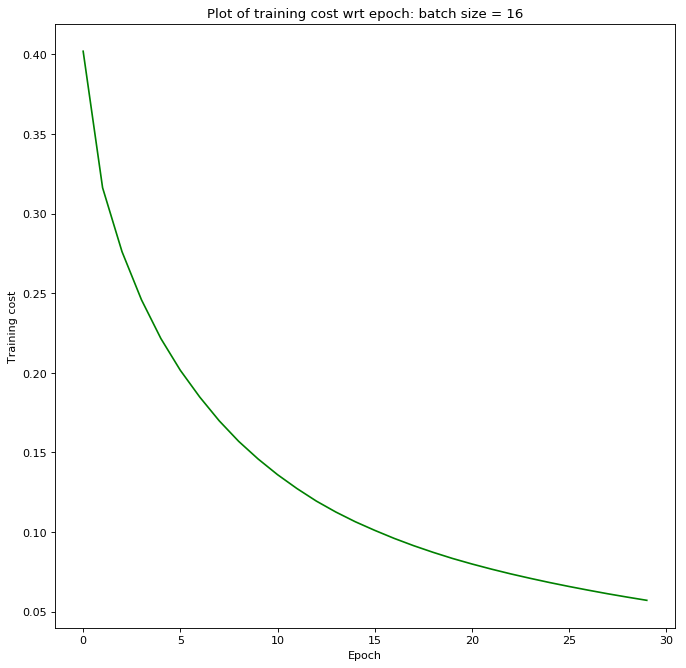

Test Accuracy = 97.39 %
Total training time for 30 epcohs =  79.433664560318


In [72]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))


BATCH_SIZE = 16
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start

        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)

        model['W_1'] = model['W_1'] - lr * gradients['W_1']
        model['b_1'] = model['b_1'] - lr * gradients['b_1']
        model['W_2'] = model['W_2'] - lr * gradients['W_2']
        model['b_2'] = model['b_2'] - lr * gradients['b_2']
    
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 16")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 64</h3>

Epoch 1: training loss = 1.2381286351966267, training time = 1.192519187927246, training_accuracy = 0.7227636363636364, val accuracy = 0.7248, test_accuracy = 0.731
Epoch 2: training loss = 0.5820040475124232, training time = 1.1941688060760498, training_accuracy = 0.849, val accuracy = 0.8582, test_accuracy = 0.8533
Epoch 3: training loss = 0.4470782588312438, training time = 1.1789088249206543, training_accuracy = 0.8795818181818181, val accuracy = 0.8854, test_accuracy = 0.8848
Epoch 4: training loss = 0.3911951828214396, training time = 1.1789968013763428, training_accuracy = 0.8910181818181818, val accuracy = 0.8972, test_accuracy = 0.8975
Epoch 5: training loss = 0.35998524828052647, training time = 1.1839148998260498, training_accuracy = 0.8990545454545454, val accuracy = 0.9038, test_accuracy = 0.9044
Epoch 6: training loss = 0.33881371409546496, training time = 1.1835973262786865, training_accuracy = 0.9037454545454545, val accuracy = 0.9088, test_accuracy = 0.9086
Epoch 7: tr

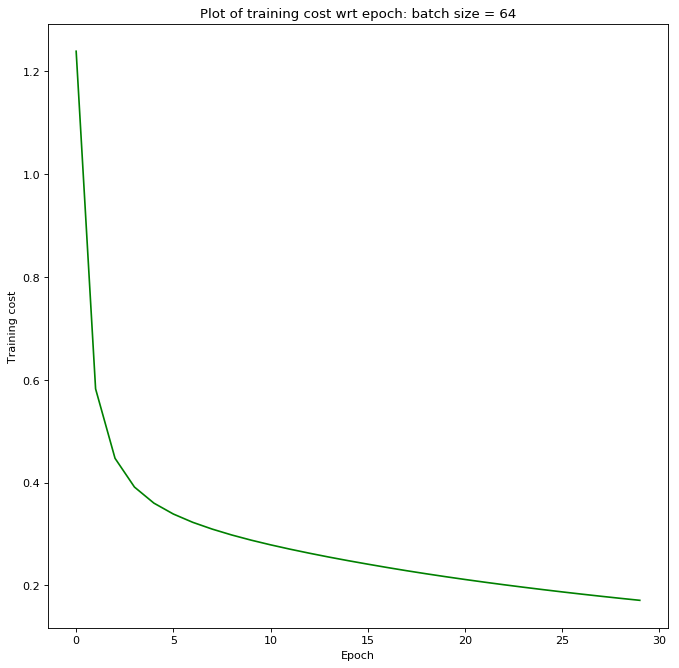

Test Accuracy = 94.99 %
Total training time for 30 epcohs =  36.22225594520569


In [73]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))


BATCH_SIZE = 64
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start

        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)

        model['W_1'] = model['W_1'] - lr * gradients['W_1']
        model['b_1'] = model['b_1'] - lr * gradients['b_1']
        model['W_2'] = model['W_2'] - lr * gradients['W_2']
        model['b_2'] = model['b_2'] - lr * gradients['b_2']
    
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 64")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 256</h3>

Epoch 1: training loss = 2.27183283002046, training time = 0.8754215240478516, training_accuracy = 0.48861818181818184, val accuracy = 0.4836, test_accuracy = 0.491
Epoch 2: training loss = 2.1287522432615913, training time = 0.8605902194976807, training_accuracy = 0.49274545454545454, val accuracy = 0.481, test_accuracy = 0.4953
Epoch 3: training loss = 1.7048702569133911, training time = 0.864208459854126, training_accuracy = 0.6445454545454545, val accuracy = 0.6458, test_accuracy = 0.6457
Epoch 4: training loss = 1.19943022722258, training time = 0.8563458919525146, training_accuracy = 0.7322363636363637, val accuracy = 0.7356, test_accuracy = 0.7407
Epoch 5: training loss = 0.9048644203477726, training time = 0.8794596195220947, training_accuracy = 0.7873818181818182, val accuracy = 0.7942, test_accuracy = 0.7925
Epoch 6: training loss = 0.7407803997205454, training time = 0.8747014999389648, training_accuracy = 0.8173454545454546, val accuracy = 0.8242, test_accuracy = 0.8195
Epo

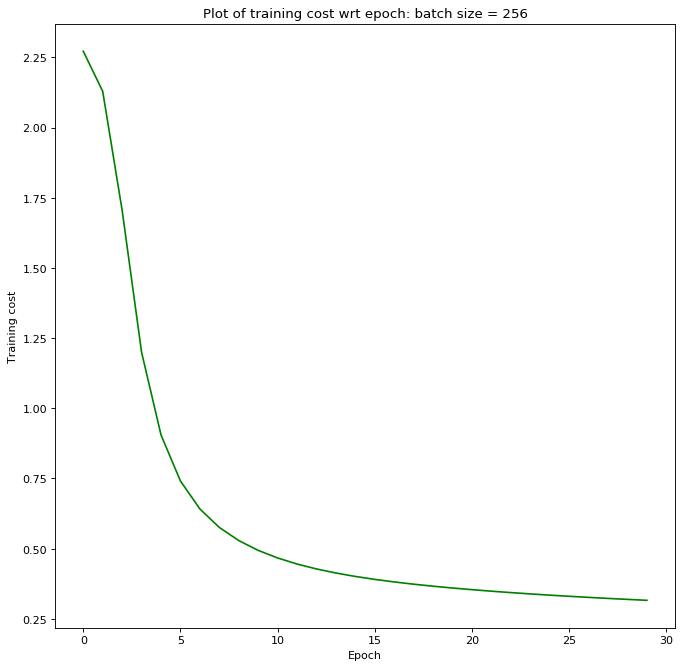

Test Accuracy = 91.56 %
Total training time for 30 epcohs =  25.586048364639282


In [74]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))


BATCH_SIZE = 256
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start

        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)

        model['W_1'] = model['W_1'] - lr * gradients['W_1']
        model['b_1'] = model['b_1'] - lr * gradients['b_1']
        model['W_2'] = model['W_2'] - lr * gradients['W_2']
        model['b_2'] = model['b_2'] - lr * gradients['b_2']
    
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 256")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 1024</h3>

Epoch 1: training loss = 2.2964362494920922, training time = 0.8103861808776855, training_accuracy = 0.3910909090909091, val accuracy = 0.3874, test_accuracy = 0.3994
Epoch 2: training loss = 2.2899503056958985, training time = 0.8091647624969482, training_accuracy = 0.4230181818181818, val accuracy = 0.4204, test_accuracy = 0.4366
Epoch 3: training loss = 2.28050910564856, training time = 0.805365800857544, training_accuracy = 0.4434909090909091, val accuracy = 0.442, test_accuracy = 0.4548
Epoch 4: training loss = 2.2663444708883804, training time = 0.800926685333252, training_accuracy = 0.44847272727272725, val accuracy = 0.4516, test_accuracy = 0.458
Epoch 5: training loss = 2.24499889287145, training time = 0.8011195659637451, training_accuracy = 0.4485818181818182, val accuracy = 0.4476, test_accuracy = 0.4539
Epoch 6: training loss = 2.213200561804924, training time = 0.7975759506225586, training_accuracy = 0.45181818181818184, val accuracy = 0.4518, test_accuracy = 0.4593
Epoch

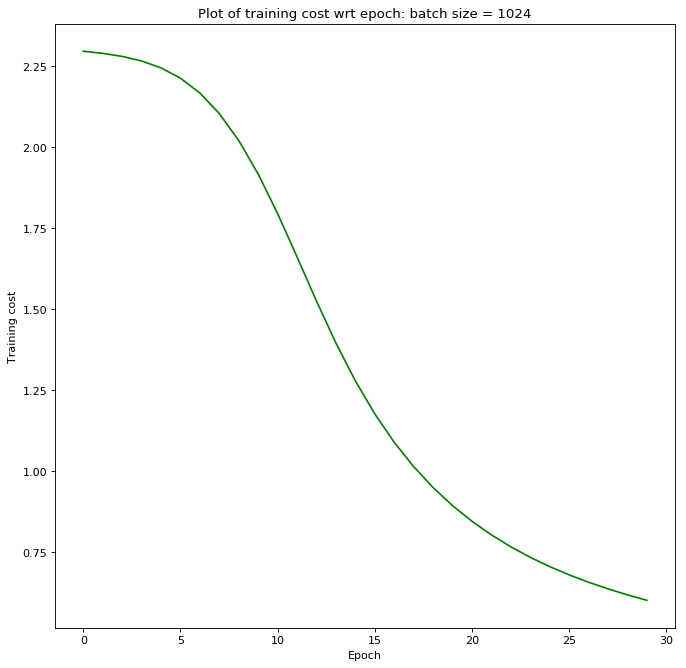

Test Accuracy = 85.28 %
Total training time for 30 epcohs =  23.761024713516235


In [75]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))


BATCH_SIZE = 1024
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start

        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)

        model['W_1'] = model['W_1'] - lr * gradients['W_1']
        model['b_1'] = model['b_1'] - lr * gradients['b_1']
        model['W_2'] = model['W_2'] - lr * gradients['W_2']
        model['b_2'] = model['b_2'] - lr * gradients['b_2']
    
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 1024")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h1> PART F: ADAM OPTIMIZER - back-propagation & training

<h3> Batch size = 16 </h3>

Epoch 1: training loss = 0.20372753240533895, training time = 6.964829683303833, training_accuracy = 0.9433090909090909, val accuracy = 0.9404, test_accuracy = 0.9417
Epoch 2: training loss = 0.18773088179729946, training time = 7.53311562538147, training_accuracy = 0.9488363636363636, val accuracy = 0.9494, test_accuracy = 0.9473
Epoch 3: training loss = 0.17746252265955306, training time = 15.50330114364624, training_accuracy = 0.9553818181818182, val accuracy = 0.952, test_accuracy = 0.9479
Epoch 4: training loss = 0.2146800148647986, training time = 17.496736764907837, training_accuracy = 0.9488363636363636, val accuracy = 0.9428, test_accuracy = 0.9417
Epoch 5: training loss = 0.17456348339920383, training time = 18.293403148651123, training_accuracy = 0.9539090909090909, val accuracy = 0.9468, test_accuracy = 0.9481
Epoch 6: training loss = 0.1813470553914333, training time = 18.641631603240967, training_accuracy = 0.9584, val accuracy = 0.949, test_accuracy = 0.9463
Epoch 7: tra

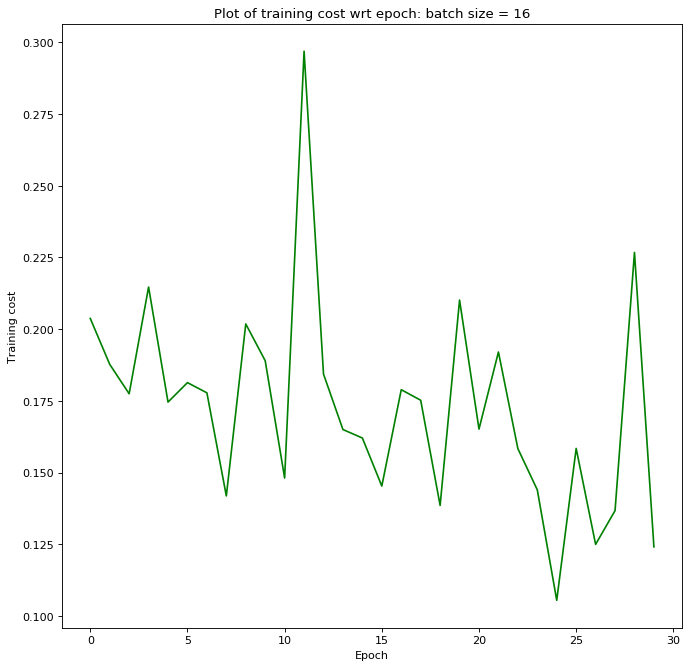

Test Accuracy = 95.76 %
Total training time for 30 epcohs =  702.383015871048


In [77]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))

BATCH_SIZE = 16
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


m = {k: np.zeros_like(v) for k,v in model.items()}
v = {k: np.zeros_like(v) for k,v in model.items()}


t = 1
for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start
#         print (mini_batch_size)
        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)
#         print (gradients)
        for key in model.keys():
            m[key] = beta_1 * m[key] + (1 - beta_1) * gradients[key]
            v[key] = beta_2 * v[key] + (1 - beta_2) * np.square(gradients[key])
            
            m_hat = m[key] / (1 - beta_1 ** t)
            v_hat = v[key] / (1 - beta_2 ** t)
            
            model[key] = model[key] - lr * (m_hat / (np.sqrt(v_hat) + epsilon))
        t+=1
      
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    

plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 16")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 64 </h3>

Epoch 1: training loss = 0.1487877886938445, training time = 2.433332681655884, training_accuracy = 0.9531090909090909, val accuracy = 0.953, test_accuracy = 0.9501
Epoch 2: training loss = 0.13141523616218986, training time = 2.322319746017456, training_accuracy = 0.9609636363636364, val accuracy = 0.9578, test_accuracy = 0.9511
Epoch 3: training loss = 0.17123273152858792, training time = 2.3045899868011475, training_accuracy = 0.9528727272727273, val accuracy = 0.9506, test_accuracy = 0.9401
Epoch 4: training loss = 0.10092539433226345, training time = 2.34688401222229, training_accuracy = 0.9700727272727273, val accuracy = 0.9632, test_accuracy = 0.9608
Epoch 5: training loss = 0.13210100745170666, training time = 2.3177874088287354, training_accuracy = 0.9661454545454545, val accuracy = 0.9592, test_accuracy = 0.9567
Epoch 6: training loss = 0.12258136510365107, training time = 2.3528425693511963, training_accuracy = 0.9683818181818182, val accuracy = 0.9574, test_accuracy = 0.952

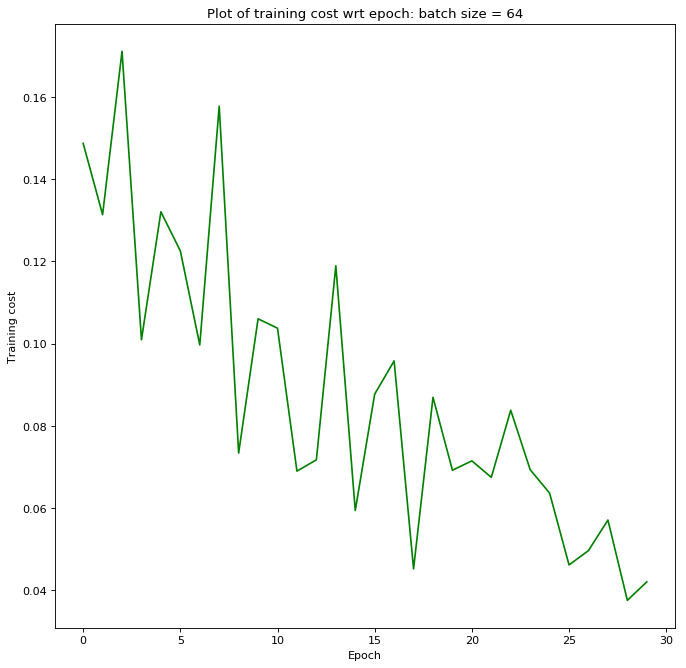

Test Accuracy = 97.13000000000001 %
Total training time for 30 epcohs =  206.8555736541748


In [78]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))


BATCH_SIZE = 64
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


m = {k: np.zeros_like(v) for k,v in model.items()}
v = {k: np.zeros_like(v) for k,v in model.items()}


t = 1
for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start
#         print (mini_batch_size)
        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)
#         print (gradients)
        for key in model.keys():
            m[key] = beta_1 * m[key] + (1 - beta_1) * gradients[key]
            v[key] = beta_2 * v[key] + (1 - beta_2) * np.square(gradients[key])
            
            m_hat = m[key] / (1 - beta_1 ** t)
            v_hat = v[key] / (1 - beta_2 ** t)
            
            model[key] = model[key] - lr * (m_hat / (np.sqrt(v_hat) + epsilon))
        t+=1
    
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    

plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 64")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 256 </h3>

Epoch 1: training loss = 0.1483972176336128, training time = 2.9542016983032227, training_accuracy = 0.9543090909090909, val accuracy = 0.9532, test_accuracy = 0.9503
Epoch 2: training loss = 0.09794544280309014, training time = 2.936941385269165, training_accuracy = 0.968709090909091, val accuracy = 0.9616, test_accuracy = 0.9614
Epoch 3: training loss = 0.08109297682722356, training time = 2.85992693901062, training_accuracy = 0.9726, val accuracy = 0.9642, test_accuracy = 0.9627
Epoch 4: training loss = 0.06959600431826041, training time = 3.1529898643493652, training_accuracy = 0.9771818181818182, val accuracy = 0.9662, test_accuracy = 0.9645
Epoch 5: training loss = 0.058469597454022214, training time = 2.9150760173797607, training_accuracy = 0.9806909090909091, val accuracy = 0.9688, test_accuracy = 0.966
Epoch 6: training loss = 0.054387387941727545, training time = 2.831801176071167, training_accuracy = 0.981890909090909, val accuracy = 0.9706, test_accuracy = 0.9672
Epoch 7: t

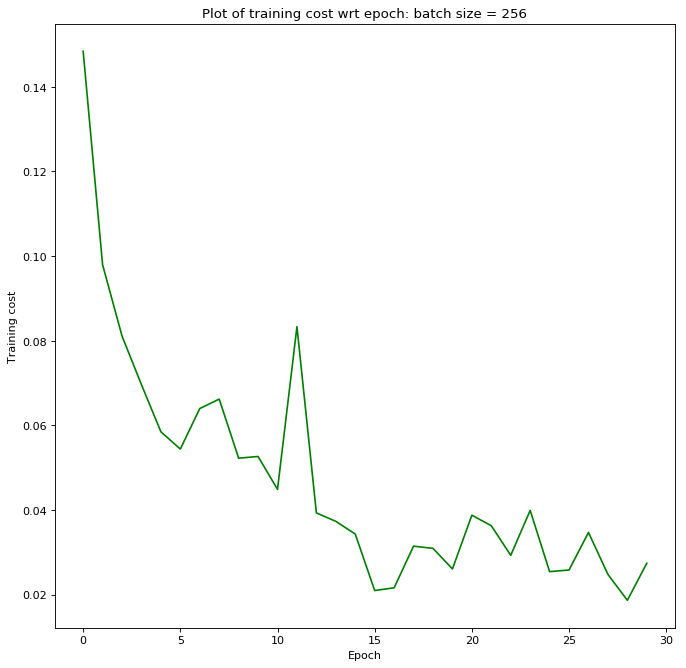

Test Accuracy = 97.61 %
Total training time for 30 epcohs =  89.85096549987793


In [79]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))

BATCH_SIZE = 256
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


m = {k: np.zeros_like(v) for k,v in model.items()}
v = {k: np.zeros_like(v) for k,v in model.items()}


t = 1
for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start
#         print (mini_batch_size)
        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)
#         print (gradients)
        for key in model.keys():
            m[key] = beta_1 * m[key] + (1 - beta_1) * gradients[key]
            v[key] = beta_2 * v[key] + (1 - beta_2) * np.square(gradients[key])
            
            m_hat = m[key] / (1 - beta_1 ** t)
            v_hat = v[key] / (1 - beta_2 ** t)
            
            model[key] = model[key] - lr * (m_hat / (np.sqrt(v_hat) + epsilon))
        t+=1

    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))
    
plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 256")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h3> Batch size = 1024 </h3>

Epoch 1: training loss = 0.24448151912470253, training time = 1.8906974792480469, training_accuracy = 0.9291636363636364, val accuracy = 0.93, test_accuracy = 0.929
Epoch 2: training loss = 0.15639366720826742, training time = 0.8754568099975586, training_accuracy = 0.9549454545454545, val accuracy = 0.9538, test_accuracy = 0.9509
Epoch 3: training loss = 0.10942435328738251, training time = 0.8763647079467773, training_accuracy = 0.9682181818181819, val accuracy = 0.962, test_accuracy = 0.9635
Epoch 4: training loss = 0.0885305860454556, training time = 0.8770973682403564, training_accuracy = 0.9738909090909091, val accuracy = 0.9686, test_accuracy = 0.968
Epoch 5: training loss = 0.07541725884116132, training time = 0.8775930404663086, training_accuracy = 0.9775818181818182, val accuracy = 0.9704, test_accuracy = 0.9692
Epoch 6: training loss = 0.06347047943892425, training time = 0.882495641708374, training_accuracy = 0.9807818181818182, val accuracy = 0.9726, test_accuracy = 0.9715

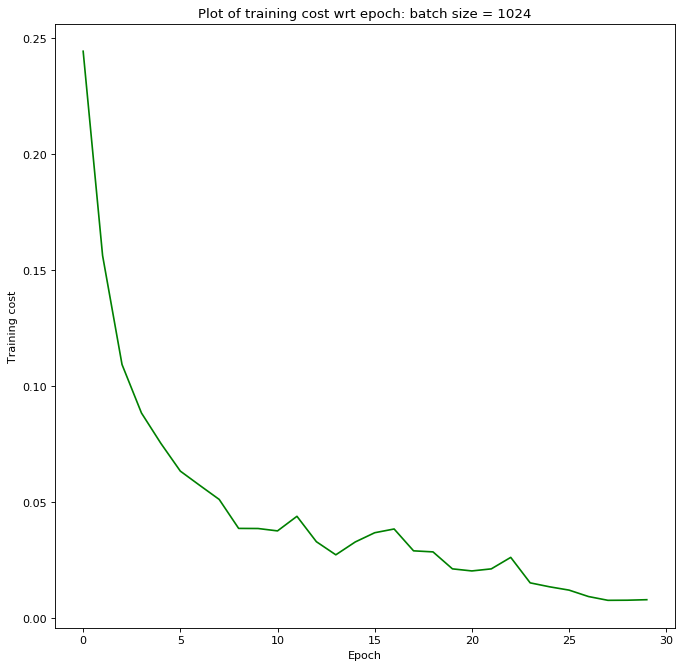

Test Accuracy = 97.85000000000001 %
Total training time for 30 epcohs =  28.002360582351685


In [80]:
model = {}
for (idx, layer) in enumerate(architecture):
    i = idx + 1
    model['W_' + str(i)] = np.random.randn(layer['output_dim'], layer['input_dim']) * 0.01
    model['b_' + str(i)] = np.zeros((layer['output_dim'], 1))

BATCH_SIZE = 1024
batches = math.floor(x_train.shape[1] // BATCH_SIZE)


test_accuracy = []
training_time = []
training_cost = []


m = {k: np.zeros_like(v) for k,v in model.items()}
v = {k: np.zeros_like(v) for k,v in model.items()}


t = 1
for i in range(EPOCHS):
    
    start_time = time.time()
    for j in range(batches):

        start = j * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_train.shape[1] - 1)
        X = x_train[:, start:end]
        Y = y_train[:, start:end]
        mini_batch_size = end - start
#         print (mini_batch_size)
        memory = forward(model, X)
        gradients = backward(model, memory, X, Y, mini_batch_size)
#         print (gradients)
        for key in model.keys():
            m[key] = beta_1 * m[key] + (1 - beta_1) * gradients[key]
            v[key] = beta_2 * v[key] + (1 - beta_2) * np.square(gradients[key])
            
            m_hat = m[key] / (1 - beta_1 ** t)
            v_hat = v[key] / (1 - beta_2 ** t)
            
            model[key] = model[key] - lr * (m_hat / (np.sqrt(v_hat) + epsilon))
        t+=1
      
    end_time = time.time()
    
    memory = forward(model, x_train)
    train_loss = cross_entropy_loss(memory['A2'], y_train)
    train_acc = np.mean(memory['A2'].argmax(axis=0) == y_train.argmax(axis=0)) 

    memory = forward(model, x_validation)
    val_loss = cross_entropy_loss(memory['A2'], y_validation)
    val_acc = np.mean(memory['A2'].argmax(axis=0) == y_validation.argmax(axis=0)) 

    memory = forward(model, x_test)
    test_loss = cross_entropy_loss(memory['A2'], y_test)
    test_acc = np.mean(memory['A2'].argmax(axis=0) == y_test.argmax(axis=0)) 
    
    time_s = end_time - start_time
    training_time.append(time_s)
    training_cost.append(train_loss)
    test_accuracy.append(test_acc)
    
    print("Epoch {}: training loss = {}, training time = {}, training_accuracy = {}, val accuracy = {}, test_accuracy = {}".format(
        i + 1, train_loss, time_s, train_acc, val_acc, test_acc))

plt.figure(figsize=(10, 10), dpi=80)
plt.plot([i for i in range(EPOCHS)], [x for x in training_cost], color='green')
plt.title("Plot of training cost wrt epoch: batch size = 1024")
plt.ylabel("Training cost")
plt.xlabel("Epoch")
plt.show()

print ("Test Accuracy = {} %".format(test_accuracy[-1]*100))
print ("Total training time for 30 epcohs = ", sum(training_time))

<h1> PART g: separate notebook </h1>